In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
import openai
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

############ 1. Data Preparation for Model Training by Combine the datasets and prepare them for training ############
# Load cleaned datasets
pair_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/pair_data_after_data_preparation.csv')
counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/counsel_chat_data_after_data_preparation.csv')
# Combine datasets
combined_data = pd.DataFrame({
    'prompt': pd.concat([pair_data['prompt'], counsel_chat_data['questionText']]),
    'response': pd.concat([
        pair_data[['hq1', 'hq2', 'mq1', 'lq1', 'lq2', 'lq3', 'lq4', 'lq5']].apply(
            lambda row: ' '.join(row.values.astype(str)), axis=1),
        counsel_chat_data['answerText']
    ])
})

# Split the data into training, validation, and testing sets
train_data, temp_data = train_test_split(
    combined_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(
    temp_data, test_size=0.66, random_state=42)
# Print the size of the train_data, val_data, and test_data
print(f"train_data: {train_data.shape}")
print(f"val_data: {val_data.shape}")
print(f"test_data: {test_data.shape}")
# Save split datasets
train_data.to_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/train_data.csv', index=False)
val_data.to_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/val_data.csv', index=False)
test_data.to_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/test_data.csv', index=False)

train_data: (1190, 2)
val_data: (173, 2)
test_data: (338, 2)


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import openai
import sacrebleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

############ 1. Data Preparation for Model Training by Combine the datasets and prepare them for training ############
# Load cleaned datasets
pair_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/pair_data_after_data_preparation.csv')
counsel_chat_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/counsel_chat_data_after_data_preparation.csv')
# Combine datasets
display(counsel_chat_data.info())
display(counsel_chat_data.head(4))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionID     1383 non-null   object
 1   questionTitle  1383 non-null   object
 2   questionText   1383 non-null   object
 3   questionUrl    1383 non-null   object
 4   topics         1376 non-null   object
 5   therapistName  1383 non-null   object
 6   therapistUrl   1383 non-null   object
 7   answerText     1383 non-null   object
 8   upvotes        1383 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 97.4+ KB


None

,questionID,questionTitle,questionText,questionUrl,topics,therapistName,therapistUrl,answerText,upvotes
0,5566fab2a64752d71ec3ca69,Escalating disagreements between mother and wife,my wife and mother are having tense disagreeme...,https://counselchat.com/questions/escalating-d...,Family Conflict,"Kristi King-Morgan, LMSW",https://counselchat.com/therapists/kristi-king...,<p>what you are describing is something psycho...,0
1,5566f94fa64752d71ec3ca64,I'm addicted to smoking. How can I stop?,"i'm planning to have baby, so i have to quit s...",https://counselchat.com/questions/i-m-addicted...,"Substance Abuse,Addiction",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>hi. good for you in planning ahead to do wh...,0
2,5567d26887a1cc0c3f3d8f46,Keeping secrets from my family,"i have secrets in my mind, and i don't know wh...",https://counselchat.com/questions/keeping-secr...,Family Conflict,Jeevna Bajaj,https://counselchat.com/therapists/jeevna-bajaj,<p>it sounds like keeping the secrets has beco...,0
3,556bed15c969ba5861709df5,The Underlying Causes of Being Possessive,i am extremely possessive in my relationships ...,https://counselchat.com/questions/the-underlyi...,"Behavioral Change,Social Relationships",Rebecca Duellman,https://counselchat.com/therapists/rebecca-due...,<p>hi there. it's great you are able to realiz...,0


In [17]:
############ 2. Model Training with GPT-4 model using the OpenAI API ############
openai.api_key = 'sk-proj-6TLzq89EwvduXuziOOVDT3BlbkFJ1TqCRGrTSdnVF1oDysKl'


def generate_responses(data_path, output_path, model_name='gpt-4'):
    data = pd.read_csv(data_path)
    responses = []

    for index, row in data.iterrows():
        prompt = row['prompt']
        try:
            response = openai.ChatCompletion.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a mental health counselor."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            responses.append(response.choices[0].message['content'].strip())
        except Exception as e:
            print(f"Error generating response for index {index}: {e}")
            responses.append("")

    data['generated_response'] = responses

    # Save the responses for further evaluation
    data.to_csv(output_path, index=False)


# Generate responses for the training, validation, and test sets
generate_responses('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/train_data.csv',
                   '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/train_generated_responses.csv')
generate_responses('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/val_data.csv',
                   '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/val_generated_responses.csv')
generate_responses('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/test_data.csv',
                   '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/test_generated_responses.csv')

In [18]:
############ 3. Evaluation of the Model Using Validation Set ############
def evaluate_responses(data_path):
    try:
        data = pd.read_csv(data_path)
        print(f"Data loaded successfully. Total records: {len(data)}")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    bleu_scores = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']

        try:
            # BLEU Score
            bleu_score = sacrebleu.sentence_bleu(
                hypothesis, [reference]).score / 100  # Normalize BLEU score
            bleu_scores.append(bleu_score)

            # ROUGE Score
            scorer = rouge_scorer.RougeScorer(
                ['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
            scores = scorer.score(reference, hypothesis)
            for key in scores:
                rouge_scores[key].append(scores[key].fmeasure)

            print(f"Processed index {index}: BLEU = {bleu_score}, ROUGE-1 = {scores['rouge1'].fmeasure}, ROUGE-2 = {
                  scores['rouge2'].fmeasure}, ROUGE-L = {scores['rougeL'].fmeasure}")

        except Exception as e:
            print(f"Error processing index {index}: {e}")

    evaluation_results = {
        'bleu': sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0,
        'rouge1': sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1']) if rouge_scores['rouge1'] else 0,
        'rouge2': sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2']) if rouge_scores['rouge2'] else 0,
        'rougeL': sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL']) if rouge_scores['rougeL'] else 0
    }

    return evaluation_results


# Evaluate the model on the validation set
validation_results = evaluate_responses(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/val_generated_responses.csv')
print("Validation Results:", validation_results)

# Evaluate the model on the test set
test_results = evaluate_responses(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/test_generated_responses.csv')
print("Test Results:", test_results)

Data loaded successfully. Total records: 173
Processed index 0: BLEU = 0.026546803284603456, ROUGE-1 = 0.41666666666666663, ROUGE-2 = 0.032258064516129024, ROUGE-L = 0.16666666666666666
Processed index 1: BLEU = 0.004522609890822975, ROUGE-1 = 0.21276595744680854, ROUGE-2 = 0.028776978417266185, ROUGE-L = 0.11347517730496455
Processed index 2: BLEU = 0.00033530154129541754, ROUGE-1 = 0.196319018404908, ROUGE-2 = 0.05555555555555556, ROUGE-L = 0.10429447852760736
Processed index 3: BLEU = 0.01417011937494102, ROUGE-1 = 0.34782608695652173, ROUGE-2 = 0.043859649122807015, ROUGE-L = 0.19130434782608693
Processed index 4: BLEU = 0.023032879451096267, ROUGE-1 = 0.4227129337539432, ROUGE-2 = 0.10793650793650794, ROUGE-L = 0.17665615141955834
Processed index 5: BLEU = 0.014150556225393603, ROUGE-1 = 0.3502304147465438, ROUGE-2 = 0.08372093023255814, ROUGE-L = 0.1751152073732719
Processed index 6: BLEU = 0.006511039219916909, ROUGE-1 = 0.2113821138211382, ROUGE-2 = 0.016528925619834708, ROUGE-

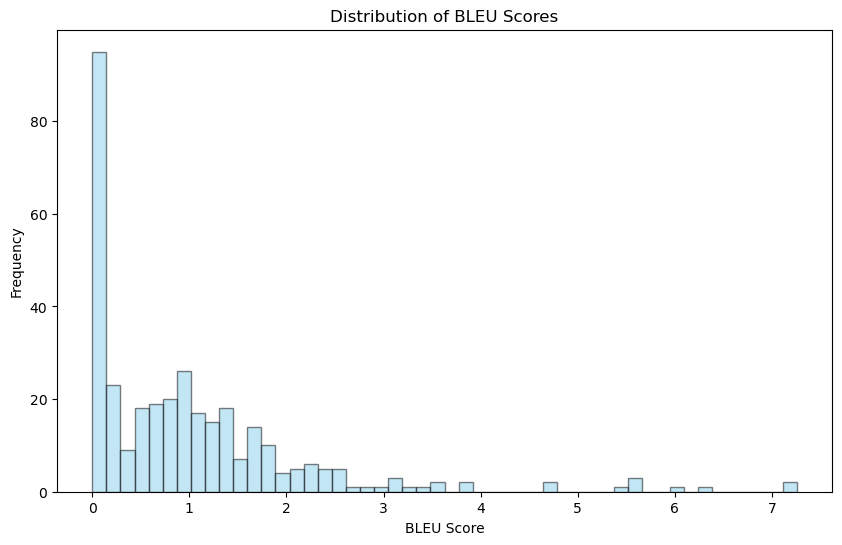

In [19]:
############ 4. Evaluate the obtained result(scores) by Analyzing BLEU Score Distribution############
def calculate_bleu_scores(data_path, max_rows=1128):
    data = pd.read_csv(data_path)
    # Slice the DataFrame to only include the first 1128 rows
    data = data.iloc[:max_rows]
    bleu_scores = []

    for index, row in data.iterrows():
        reference = row['response']
        hypothesis = row['generated_response']
        bleu_score = sacrebleu.sentence_bleu(hypothesis, [reference]).score
        bleu_scores.append(bleu_score)

    data['bleu_score'] = bleu_scores
    return data


evaluated_data = calculate_bleu_scores(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/test_generated_responses.csv')

# Plot Distribution:
# Use a histogram to plot the distribution of BLEU scores in the evaluated data, create a histogram with 20 bins and larger size
plt.figure(figsize=(10, 6))
plt.hist(evaluated_data['bleu_score'], bins=50,
         color='skyblue', edgecolor='black', alpha=0.5)
plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
# Save the plot as an EPS file with 600 dpi
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/bleu_score_distribution.eps', format='eps', dpi=600)
plt.show()

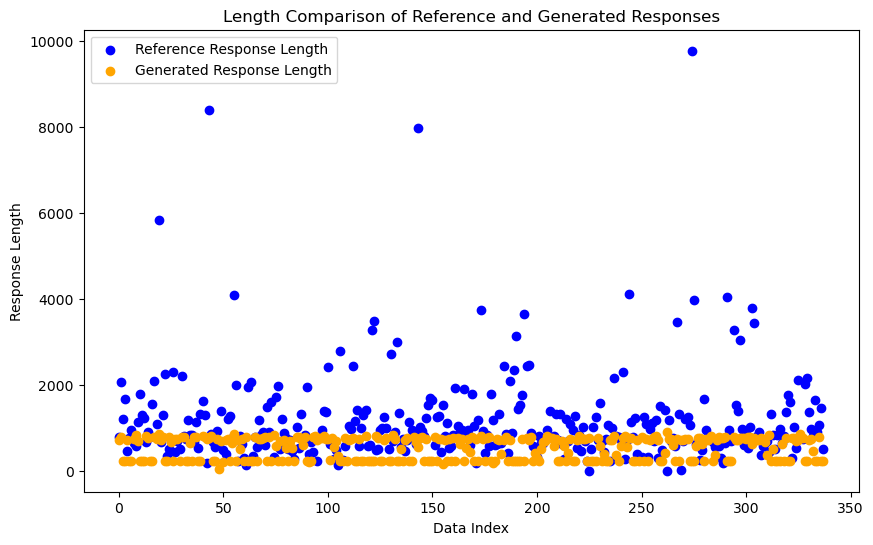

In [20]:
############ 5.a. Evaluate the result to Check for Overly Simplistic Text by analyzing the generated responses Length Analysis############
# Length Analysis:
# Compare the lengths of generated responses and reference responses.
evaluated_data['reference_length'] = evaluated_data['response'].apply(len)
evaluated_data['generated_length'] = evaluated_data['generated_response'].apply(
    len)

# Make scatter plot of size 10, 6
plt.figure(figsize=(10, 6))
plt.scatter(evaluated_data.index,
            evaluated_data['reference_length'], color='blue', label='Reference Response Length')
plt.scatter(evaluated_data.index,
            evaluated_data['generated_length'], color='orange', label='Generated Response Length')

plt.xlabel('Data Index')
plt.ylabel('Response Length')
plt.title('Length Comparison of Reference and Generated Responses')
plt.legend()
# Save the plot as an EPS file with 600 dpi
plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/length_analysis.eps', format='eps', dpi=600)
plt.show()

In [21]:
############ 5.b. Content Analysis############
# Check if the generated responses are repetitive or lack variety

from collections import Counter

generated_responses = evaluated_data['generated_response'].tolist()
word_counts = Counter(" ".join(generated_responses).split())

common_words = word_counts.most_common(20)
print("Most common words in generated responses:")
for word, count in common_words:
    print(f"{word}: {count}")

Most common words in generated responses:
to: 1401
a: 948
and: 781
your: 689
that: 638
you: 617
the: 537
or: 400
with: 373
It's: 372
can: 370
of: 363
you're: 343
I'm: 328
in: 326
important: 298
be: 281
really: 280
help: 270
is: 254


In [22]:
############ Evaluate the result to ensure that the training, validation, and test sets are correctly split and that no overlap exists.############

from sklearn.model_selection import train_test_split


def check_data_leakage(train_data_path, val_data_path, test_data_path):
    train_data = pd.read_csv(train_data_path)
    val_data = pd.read_csv(val_data_path)
    test_data = pd.read_csv(test_data_path)

    train_prompts = set(train_data['prompt'])
    val_prompts = set(val_data['prompt'])
    test_prompts = set(test_data['prompt'])

    overlap_val_train = train_prompts.intersection(val_prompts)
    overlap_test_train = train_prompts.intersection(test_prompts)
    overlap_test_val = val_prompts.intersection(test_prompts)

    if overlap_val_train or overlap_test_train or overlap_test_val:
        print("Data leakage detected!")
        if overlap_val_train:
            print(f"Overlap between training and validation sets: {
                  overlap_val_train}")
        if overlap_test_train:
            print(f"Overlap between training and test sets: {
                  overlap_test_train}")
        if overlap_test_val:
            print(f"Overlap between validation and test sets: {
                  overlap_test_val}")
    else:
        print("No data leakage detected.")


check_data_leakage('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/train_data.csv',
                   '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/val_data.csv', '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/test_data.csv')

Data leakage detected!
Overlap between training and validation sets: {"i feel like i am internally screaming all the time. externally, i am calm, but i have this intense, unidentifiable emotion constantly. i don't feel sad. i don't cry a lot. i feel rather emotionally distant other than the internal screaming. it kind of feels like i'm a caged animal.", 'i never feel like myself. i can’t even think straight anymore. i start stuttering and i can’t remember anything. i always get nervous and usually talk myself down but recently end up fighting with, what feels like, someone else. i don’t know why i feel this way, but i hate it.', "we had great chemistry, but then he became distant. i had the feeling that i can't be without him. as soon as i felt the difference, i was scared to lose him. i started freaking out if he did not answer, thinking that something bad happened.", "i've never been able to talk with my parents. my parents are in their sixties while i am a teenager. i love both of t

### Sentiment Analysis for each of the rows


In [7]:
from textblob import TextBlob
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
############ 6. Sentiment Analysis and Emotion Detection ############

# Function to perform sentiment analysis


def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Function to perform emotion detection


def detect_emotions(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

# Adding sentiment analysis and emotion detection to the evaluation


def evaluate_responses_with_sentiment(data):
    # Perform sentiment analysis
    data['sentiment'] = data['generated_response'].apply(
        lambda x: analyze_sentiment(x))

    # Perform emotion detection
    data['emotion'] = data['generated_response'].apply(
        lambda x: detect_emotions(x))

    return data


evaluated_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/test_generated_responses.csv')
# Apply the extended evaluation function
evaluated_data_with_sentiment = evaluate_responses_with_sentiment(
    evaluated_data)

# Display some sentiment and emotion analysis results
display(evaluated_data_with_sentiment[[
    'generated_response', 'sentiment', 'emotion']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dipendrapant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,generated_response,sentiment,emotion
0,It's understandable that you're feeling frustr...,-0.009167,"{'neg': 0.147, 'neu': 0.703, 'pos': 0.15, 'com..."
1,"This may be a difficult situation, but it's im...",0.051667,"{'neg': 0.106, 'neu': 0.79, 'pos': 0.104, 'com..."
2,"I'm really sorry that you're feeling this way,...",-0.100000,"{'neg': 0.027, 'neu': 0.736, 'pos': 0.237, 'co..."
3,"I'm really sorry that you're feeling this way,...",-0.100000,"{'neg': 0.027, 'neu': 0.736, 'pos': 0.237, 'co..."
4,It seems like you're experiencing some social ...,0.096548,"{'neg': 0.088, 'neu': 0.712, 'pos': 0.2, 'comp..."


### Sentiment Analysis: Summarizing Sentiment and Emotion Scores


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dipendrapant/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                  generated_response  sentiment    pos    neu  \
0  It's understandable that you're feeling frustr...  -0.009167  0.150  0.703   
1  This may be a difficult situation, but it's im...   0.051667  0.104  0.790   
2  I'm really sorry that you're feeling this way,...  -0.100000  0.237  0.736   
3  I'm really sorry that you're feeling this way,...  -0.100000  0.237  0.736   
4  It seems like you're experiencing some social ...   0.096548  0.200  0.712   

     neg  compound  
0  0.147    0.1130  
1  0.106   -0.3160  
2  0.027    0.8832  
3  0.027    0.8832  
4  0.088    0.9431  
Overall Sentiment Score: 0.0438061010544784
Average Emotion Scores:
pos         0.198095
neu         0.742763
neg         0.059151
compound    0.708569
dtype: float64


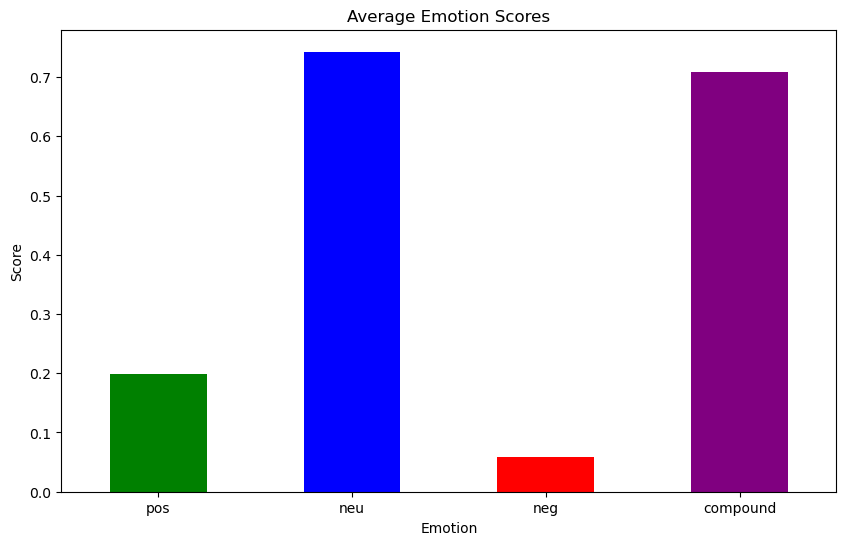

In [9]:
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

############ 6. Sentiment Analysis and Emotion Detection ############

# Function to perform sentiment analysis


def analyze_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Function to perform emotion detection


def detect_emotions(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)

# Adding sentiment analysis and emotion detection to the evaluation


def evaluate_responses_with_sentiment(data):
    # Perform sentiment analysis
    data['sentiment'] = data['generated_response'].apply(
        lambda x: analyze_sentiment(x))

    # Perform emotion detection
    emotion_scores = data['generated_response'].apply(
        lambda x: detect_emotions(x))
    data = pd.concat([data, emotion_scores.apply(pd.Series)], axis=1)

    return data


# Apply the extended evaluation function
evaluated_data = pd.read_csv(
    '/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/test_generated_responses.csv')
# Apply the extended evaluation function
evaluated_data_with_sentiment = evaluate_responses_with_sentiment(
    evaluated_data)

# Display some sentiment and emotion analysis results
print(evaluated_data_with_sentiment[[
      'generated_response', 'sentiment', 'pos', 'neu', 'neg', 'compound']].head())

############ 7. Summarize Sentiment and Emotion Scores ############

# Calculate overall sentiment score
overall_sentiment = evaluated_data_with_sentiment['sentiment'].mean()
print(f"Overall Sentiment Score: {overall_sentiment}")

# Calculate average emotion scores
average_emotions = evaluated_data_with_sentiment[[
    'pos', 'neu', 'neg', 'compound']].mean()
print(f"Average Emotion Scores:\n{average_emotions}")

# Plotting the emotion distributions
plt.figure(figsize=(10, 6))
average_emotions.plot(kind='bar', color=['green', 'blue', 'red', 'purple'])
plt.title('Average Emotion Scores')
plt.ylabel('Score')
plt.xlabel('Emotion')
plt.xticks(rotation=0)
# plt.savefig('/Users/dipendrapant/Library/CloudStorage/OneDrive-NTNU/ForFun/npj_digital_medicine/code/data/result/v2/emotion_scores.eps', format='eps', dpi=600)
plt.show()